In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
figSize = (8, 6)

# Read Data
Config = ("SumE", "NHits","RecoE_MLP")
Layer = (40,45,50,55,60)
TotalX0=24.0#for 60 layers
colors = ['blue', 'green', 'red','orange','purple','brown','cyan','magenta']
dataPath = "/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate"
particleEnergy = []
meanGamma = []
meanGammaErr = []
peakGamma = []
peakGammaErr = []
resGamma = []
resGammaErr = []

for layer in Layer:
    layer_particleEnergy = []
    layer_meanGamma = []
    layer_meanGammaErr = []
    layer_peakGamma = []
    layer_peakGammaErr = []
    layer_resGamma = []
    layer_resGammaErr = []
    dataPath_layer = os.path.join(dataPath, f"Merged_X5.0mm_Y5.0mm_Si0.75mm_layer{layer}_in{layer*2}/Reco_Results")
    
    for i_config in range(len(Config)):
        fileName = os.path.join(dataPath_layer, f"{Config[i_config]}_Fit.csv")
        df = pd.read_csv(fileName)
        
        layer_particleEnergy.append(df["ParticleEnergy"].to_numpy())
        layer_meanGamma.append(df["Mean_Gamma"].to_numpy())
        layer_meanGammaErr.append(df["Mean_Gamma_Error"].to_numpy())
        layer_peakGamma.append(df["Peak_Gamma"].to_numpy())
        layer_peakGammaErr.append(df["Peak_Gamma_Error"].to_numpy())
        layer_resGamma.append(df["Res_Gamma"].to_numpy())
        layer_resGammaErr.append(df["Res_Gamma_Error"].to_numpy())
        
        print(f"Loaded {fileName}")
    
    particleEnergy.append(layer_particleEnergy)
    meanGamma.append(layer_meanGamma)
    meanGammaErr.append(layer_meanGammaErr)
    peakGamma.append(layer_peakGamma)
    peakGammaErr.append(layer_peakGammaErr)
    resGamma.append(layer_resGamma)
    resGammaErr.append(layer_resGammaErr)



Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/Reco_Results/SumE_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/Reco_Results/NHits_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/Reco_Results/RecoE_MLP_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer45_in90/Reco_Results/SumE_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer45_in90/Reco_Results/NHits_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer45_in90/Reco_Results/RecoE_MLP_Fit.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_

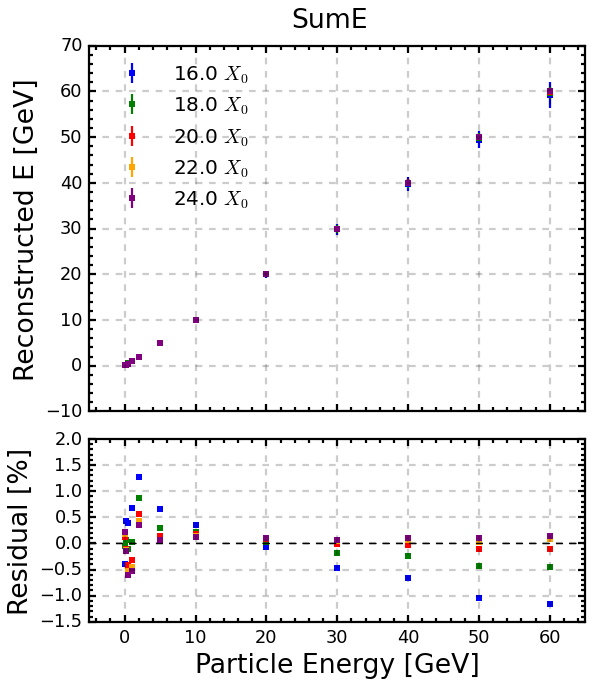

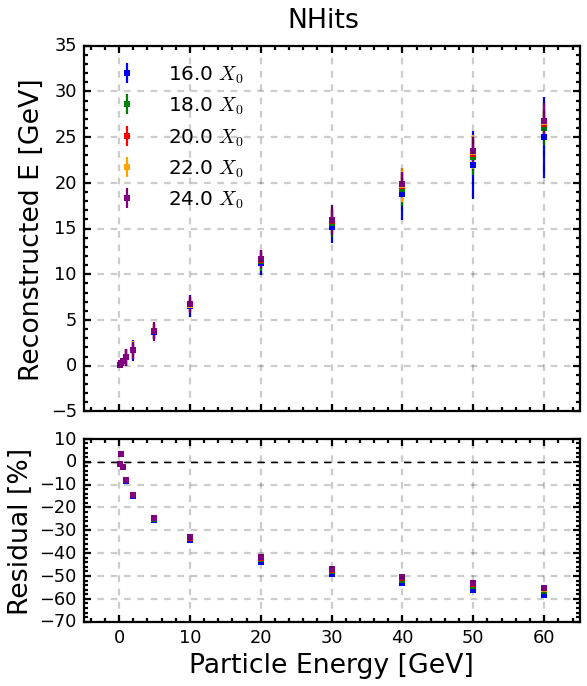

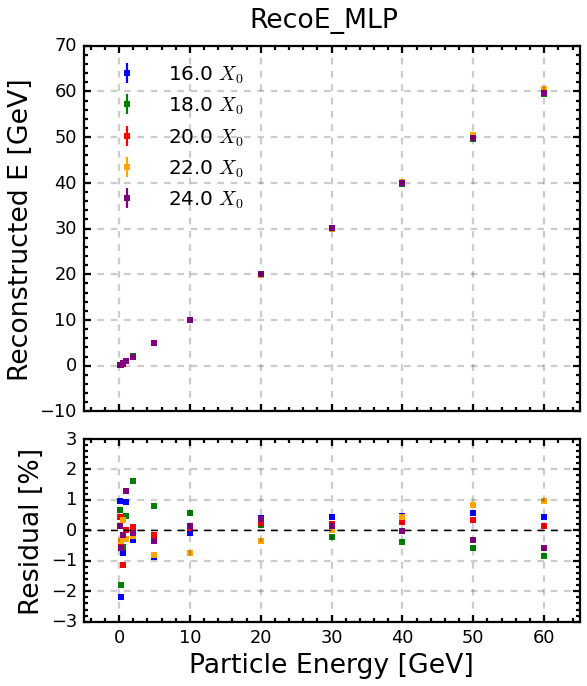

In [2]:

# Linearity and Resolution
def linear_func(x, a, b):
    return a * x + b

def fitAndResidualRatio(x, y, fit_range=(0,30)):
    """Linear fit and return coefficients, fit values, and relative residuals."""
    a0 = (y[-1] - y[0]) / (x[-1] - x[0])
    b0 = y[0]
    p0 = [a0, b0]
    upper_bound = [5*a0, np.inf]
    lower_bound = [0, -np.inf]  # Ensure slope is non-negative
    mask = (x >= fit_range[0]) & (x <= fit_range[1])
    coeffs, cov = curve_fit(linear_func, x[mask], y[mask], p0=p0, bounds=(lower_bound, upper_bound),sigma=x[mask], absolute_sigma=True)
    fitVals = linear_func(x, *coeffs)
    residualRatio = (y - fitVals) / fitVals
    return coeffs, fitVals, residualRatio
fitGamma,ResGamma = [],[]

for config_idx, config in enumerate(Config):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(figSize[0], figSize[1]*1.6),
                                   sharex=True, gridspec_kw={'height_ratios':[1, 0.5], 'hspace':0.1})
    
    for layer_idx, layer in enumerate(Layer):
        x = particleEnergy[layer_idx][config_idx]
        y = peakGamma[layer_idx][config_idx]
        y_err = peakGammaErr[layer_idx][config_idx]
        Materialx0 = TotalX0 * layer / 60.0
        # Calib
        fit_range = (0, 0.8) if config == "NHits" else (0, 60)
        coeff, fitVals, residual = fitAndResidualRatio(x, y, fit_range=fit_range)
        y_calib = (y - coeff[1]) / coeff[0]
        residual = (y_calib-x)/x

        # 主图：Reconstructed E
        ax1.errorbar(x, y_calib, yerr=y_err, fmt='s', capsize=4,
                     color=colors[layer_idx], label=fr"{Materialx0:.1f} $X_0$")
        ax1.set_ylabel("Reconstructed E [GeV]")
        ax1.set_xlim(-5, 65)
        ax1.grid(True, linestyle='--', alpha=0.2)
        ax1.legend(loc='upper left', fontsize=18)

        # 残差图
        ax2.plot(x, residual*100, 's', color=colors[layer_idx], label=fr"{Materialx0:.1f} $X_0$")
        ax2.axhline(0, color='black', lw=1, linestyle='--')
        ax2.set_xlabel("Particle Energy [GeV]")
        ax2.set_ylabel("Residual [%]")
        ax2.grid(True, linestyle='--', alpha=0.2)

    fig.suptitle(f"{config}", fontsize=24, y=0.95)
    plt.show()




/tmp/ipykernel_3065956/144610385.py:6: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.sqrt(E)


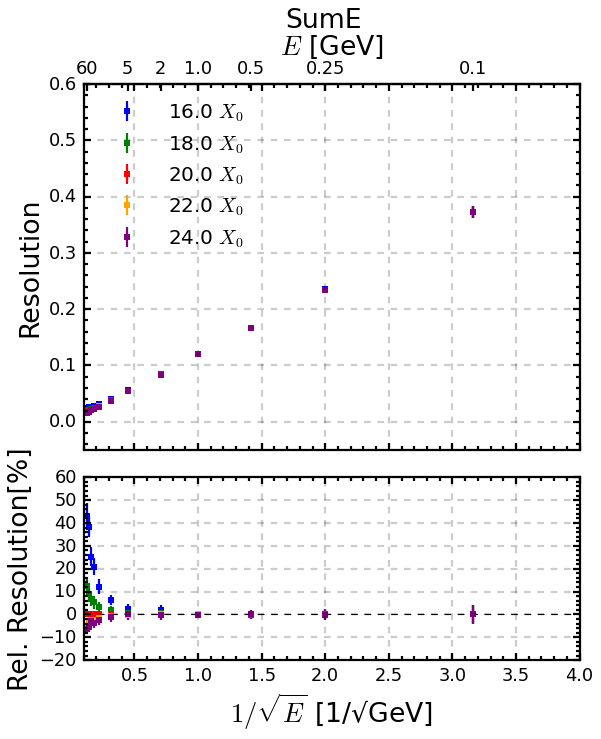

/tmp/ipykernel_3065956/144610385.py:6: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.sqrt(E)


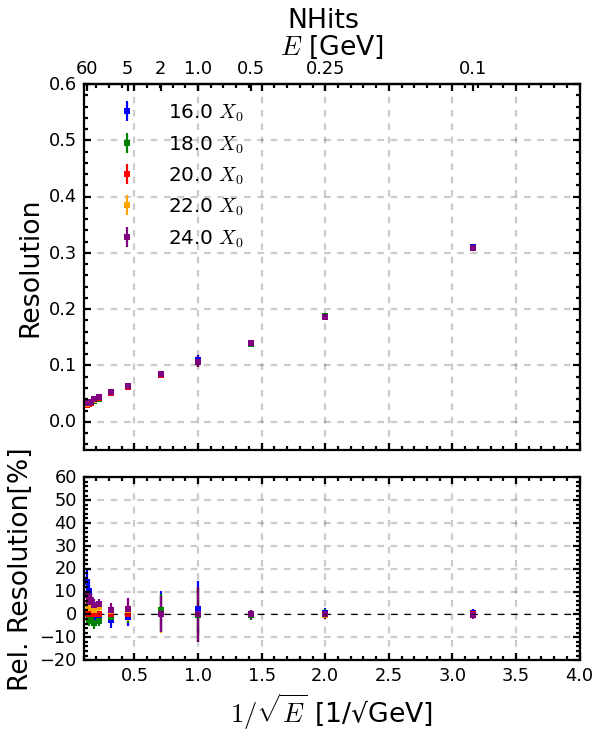

/tmp/ipykernel_3065956/144610385.py:6: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.sqrt(E)


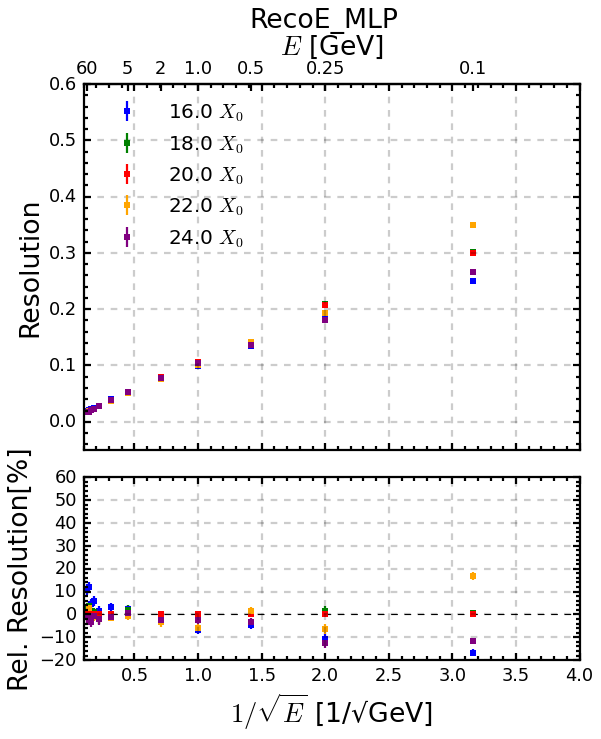

In [3]:
MarkerSize = 10

def forward(x):
    return 1 / (x**2)
def inverse(E):
    return 1 / np.sqrt(E)

for i_c, config in enumerate(Config):
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(figSize[0], figSize[1]*1.6),
        sharex=True, gridspec_kw={'height_ratios': [1, 0.5], 'hspace': 0.1}
    )

    # Secondary x-axis
    secax = ax1.secondary_xaxis("top", functions=(forward, inverse))
    secax.set_xlabel(r"$E$ [GeV]")
    E_ticks = [0.1, 0.25, 0.5, 1.0, 2, 5, 60]
    secax.set_xticks(E_ticks)
    secax.set_xticklabels(E_ticks)
    secax.xaxis.set_minor_locator(plt.NullLocator())
    secax.xaxis.set_tick_params(which='both', top=True, labeltop=True, bottom=False, labelbottom=False)

    # Reference: first layer
    ref_layer = 2
    x_ref = 1 / np.sqrt(particleEnergy[ref_layer][i_c])
    y_ref = np.array(resGamma[ref_layer][i_c])
    y_ref_err = np.array(resGammaErr[ref_layer][i_c])

    for layer_idx, layer in enumerate(Layer):
        x_vals = 1 / np.sqrt(particleEnergy[layer_idx][i_c])
        y_vals = np.array(resGamma[layer_idx][i_c])
        y_errs = np.array(resGammaErr[layer_idx][i_c])
        Materialx0 = TotalX0 * layer / 60.0
        # Main resolution plot
        ax1.errorbar(x_vals, y_vals, yerr=y_errs,
                     fmt='s', capsize=4, label=fr"{Materialx0:.1f} $X_0$",
                     color=colors[layer_idx])
        # Residual plot
        if layer_idx == ref_layer:
            ax2.errorbar(x_vals, np.zeros_like(y_vals), yerr=y_errs / y_ref,
                         fmt='s', capsize=4, label=fr"Layer {layer*2} (ref)",
                         color=colors[layer_idx])
        else:
            residual = (y_vals - y_ref) / y_ref
            residual_err = np.sqrt((y_errs / y_ref)**2 + (y_ref_err * y_vals / y_ref**2)**2)
            ax2.errorbar(x_vals, residual * 100, yerr=residual_err * 100,
                         fmt='s', capsize=4, label=f"Layer {layer*2} / Layer {Layer[ref_layer]*2}",
                         color=colors[layer_idx])

    ax1.set_ylabel("Resolution")
    ax1.set_xlim(0.1, 4)
    ax1.set_ylim(-0.05, 0.6)
    ax1.grid(True, linestyle='--', alpha=0.2)
    ax1.legend(loc='upper left', fontsize=18)

    ax2.axhline(0, color='black', lw=1, linestyle='--')
    ax2.set_xlabel(r"$1/\sqrt{E}$ [1/√GeV]")
    ax2.set_ylabel("Rel. Resolution[%]")
    ax2.set_ylim(-20, 60)
    ax2.grid(True, linestyle='--', alpha=0.2)
    #ax2.legend(loc='upper right')

    fig.suptitle(f"{config}", fontsize=24, y=1)
    plt.show()
